In [1]:
!pip install -q kaggle

In [2]:
# from google.colab import files
# files.upload()

In [3]:
!mkdir ~/.kaggle

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [8]:
!kaggle competitions download -c aptos2019-blindness-detection

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.


In [11]:
!chmod 600 /content/kaggle.json



In [13]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.49G/9.51G [01:41<00:00, 177MB/s]
100% 9.51G/9.51G [01:41<00:00, 100MB/s]


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm

In [ ]:
!unzip \*.zip && rm *.zip

Archive:  aptos2019-blindness-detection.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_images/0005cfc8afb6.png  
  inflating: test_images/003f0afdcd15.png  
  inflating: test_images/006efc72b638.png  
  inflating: test_images/00836aaacf06.png  
  inflating: test_images/009245722fa4.png  
  inflating: test_images/009c019a7309.png  
  inflating: test_images/010d915e229a.png  
  inflating: test_images/0111b949947e.png  
  inflating: test_images/01499815e469.png  
  inflating: test_images/0167076e7089.png  
  inflating: test_images/01c31b10ab99.png  
  inflating: test_images/01c5ba195207.png  
  inflating: test_images/01e4d86b3a30.png  
  inflating: test_images/020921b796d5.png  
  inflating: test_images/020f6983114d.png  
  inflating: test_images/021c207614d6.png  
  inflating: test_images/0229c0a80d42.png  
  inflating: test_images/024d0a225db1.png  
  inflating: test_images/0268f4382c67.png  
  inflating: test_images/0299d97f31f7.png  


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm



In [23]:
# loading the dataset
train_df = pd.read_csv('train.csv')

In [24]:
# top 5 rows of dataset
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: ylabel='Frequency'>

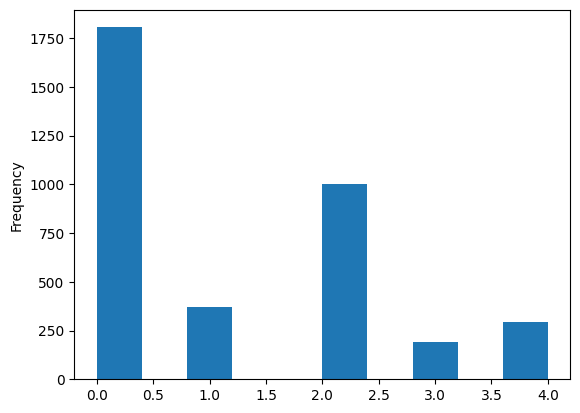

In [25]:
# distribution of classes in dataset ( which is imbalanced )
train_df['diagnosis'].plot(kind='hist')

In [26]:
# dimension of csv train file
train_df.shape

(3662, 2)

In [27]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

Preprocessing the image

In [28]:
def preprocess_image(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

def preprocess_image1(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

In [32]:
y_train = pd.get_dummies(train_df['diagnosis']).values

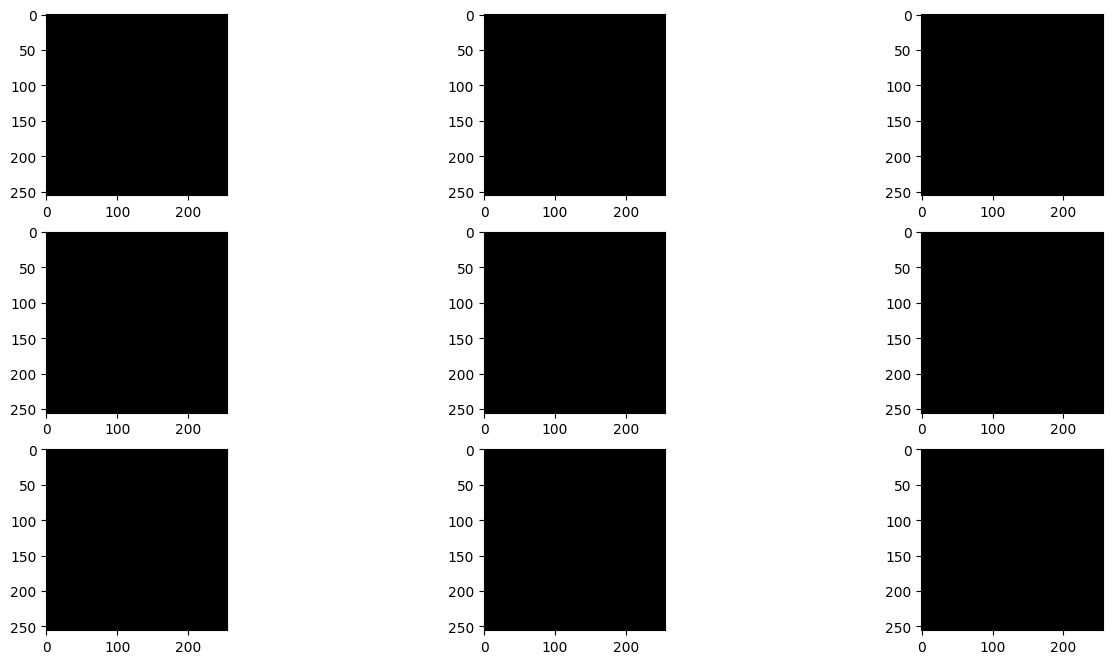

In [33]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train1[i])

In [34]:
del N1
gc.collect()

25931

In [35]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
np.save('y_train1.npy',y_train_multi)
np.save('x_train1.npy',x_train1)

Training Model

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201

In [39]:
x_train1 = np.load('x_train1.npy')
y_train1 = np.load('y_train1.npy')

In [40]:
from sklearn.model_selection import train_test_split
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train1, y_train1,
    random_state=42
)
print("train-validation splitted ...")

train-validation splitted ...


In [41]:
del x_train1,y_train1
gc.collect()

10

In [42]:
from keras.preprocessing.image import ImageDataGenerator
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        rotation_range=20 ,      # Degree range for random rotations
        zoom_range=0.1
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain,batch_size=16,seed=20031976)
print("Image data augmentated ...")

Image data augmentated ...


In [43]:
import tensorflow as tf
import keras.backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [44]:
gc.collect()

0

In [45]:
effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)

29084464/29084464 [==============================] - 0s 0us/step


In [47]:
model = Sequential()
model.add(effnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy',f1],
)


In [48]:
gc.collect()


13226

In [49]:
# callback to keep track of kappa score during training
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
import json
class KappaMetrics(Callback):
    i=0
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"Epoch: {epoch+1} val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model. - "+str(KappaMetrics.i))
            model_json = self.model.to_json()
            with open("model_in_json"+str(KappaMetrics.i)+".json", "w") as json_file:
                json.dump(model_json, json_file)
            self.model.save_weights("model_weights"+str(KappaMetrics.i)+".h5")
            KappaMetrics.i+=1
        return

kappa_score = KappaMetrics()